In [1]:
# the ususal import
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# the nmr file
file = "..//..//data/spectrum_processed.csv"

In [8]:
# from now on everthing is put into nicely packed functions

In [55]:
def norm_data(y):
     # since the spectra has a constant baseline this can be defined as the median,
    # most datapoint should lie araound the baseline
    # dispaly raw spec to see
    baseline = np.median(y)
    
    #  substract the median
    # now the baseline is 0 
    y=y-np.median(y) 
    
    # divide by the maximum value, to scale the data beween baseline and maximum between 0 and 1    
    y=y/y.max()
    
    #return the new y
    return y

def detect_over_threshold(x,y,th, display_intermediates = False,
                          ):
    over_th= y>th # boolean array, which values are over threshold
    
    
    if display_intermediates:
        # for plotting its easier to zoom in the relevant range
        # for this the detect the minimu and maximum x value and add/substract 10% of the overall range
        zoom_range_min=x[over_th].min()
        zoom_range_max=x[over_th].max()
        add_range= 0.1*(zoom_range_max-zoom_range_min)
        zoom_range_min = zoom_range_min - add_range
        zoom_range_max = zoom_range_max + add_range
    
        plt.plot(x,over_th)
        plt.title("peak detect - over threshold")
        plt.xlim(zoom_range_min,zoom_range_max)
        plt.show()
        plt.close()
    
    over_th = over_th.astype(int) # turns the array from a boolean array (True, False) to an integer array (1,0)
    
    # a detected peak begins when the value in the over_th changes from 0 to 1
    # and a detected peak end when the value in the over_th changes from 1 to 0
    # if we substract all values from the previous value the resulting array is 1 (1-0) a peak begins
    # and -1 (0-1) where we leav the peak
    over_th_diff = over_th[1:]-over_th[:-1] # all values starting from the 2nd one till the end, minus all values from the beginning untill the last value (excluded)
    
    # since the new array is one element shorter than the original but whe still want to have the same size:
    # we create a new 0 filled array with the same dimensions as x
    peak_in_out=np.zeros_like(x)
    
    # then the fallues from the second elemnt till the and are set to the difference
    peak_in_out[1:] = over_th_diff
    
    if display_intermediates:
        plt.plot(x,peak_in_out)
        plt.title("peak detect - peak_in_out")
        plt.xlim(zoom_range_min,zoom_range_max)
        plt.show()
        plt.close()
    
    # new boolean array for entering and leaving peaks
    enter_peak = peak_in_out==1
    leave_peak = peak_in_out==-1
    if display_intermediates:
        plt.plot(x,enter_peak,label="enter_peak")
        plt.plot(x,leave_peak,label="leave_peak")
        plt.title("peak detect - enter/leave peak")
        plt.xlim(zoom_range_min,zoom_range_max)
        plt.legend()
        plt.show()
        plt.close()
    
    return enter_peak,leave_peak

def detect_peaks(x,
                 y,
                 peak_threshold, # minimum hight to be counted as a signal
                 display_intermediates=False,
                ):
        
    enter_peak,leave_peak = detect_over_threshold(x,y,peak_threshold)
    #whe get all the x values where we anter or leave a peak
    enter_peak_x = x[enter_peak]
    leave_peak_x = x[leave_peak]
    
    # and store each enter and lea value in an lsit
    peak_borders=[] # empty list
    for i in range(len(enter_peak_x)): # iterate over all numbers from 0 to the number of peak entries
        peak_borders.append([x[enter_peak][i],x[leave_peak][i]]) # add a pair of the ith enriey x value and the ith leav x value to the list
    
    
    if display_intermediates:
        for x_entry, x_leave in peak_borders:
            plt.plot(x,y)
            plt.axvspan(x_entry, x_leave, alpha=0.5, color='red')
        plt.xlim(zoom_range_min,zoom_range_max)
        plt.show()
        plt.close()
        
    # now the true peak is the maximum in each of the detected regions:
    peaks=[] # empty list
    for peak in peak_borders: #iteerate over all borders
        # the unpacked lower and upper values
        lower_x = peak[0] 
        upper_x = peak[1]

        # we now need the position in the array of these values
        # to get the corresponding y values, which we need for the maximum
        
        # For this we compare all x values against the boorder values, 
        # which creates an array where every value is False except teh matching one
        # and then we use argmax to get the position of the maximum
        # since avery value is False(0) except the one we are looking for, wich is True(1)
        # the reult is the index of the value
        
        lower_x_idx = (x==lower_x).argmax()
        upper_x_idx = (x==upper_x).argmax()
        
        # now whe want to get the position of the y value in the respective regions
        # we have to add the lower_x_idx since argmax gets to position in the array we use it on
        # e.g. if the maximum would be the first vale, which would correlate to the lower_x_idx value, armax would return 0
        # by adding lower_x_idx whe shift the result of argmax to the correct position in the 'real values'
        y_max_idx = y[lower_x_idx:upper_x_idx+1].argmax() + lower_x_idx # 
        
        # whe then add an dictionary of all relevant data to the peaks list
        peaks.append(
            {'idx':y_max_idx,
             'y_value':y[y_max_idx],
             'x_value':x[y_max_idx],
            }
        )
        
    # and return the peaks
    return peaks

def find_overlaps(peaks):
    peaks=sorted(peaks,key=lambda d: d["idx"] ) # garantiert peak sortierung
    peaks_with_overlap=set() # like unique lists
    
    for peak_idx in range(1,len(peaks)):
        if peaks[peak_idx]['idx'] <=  peaks[peak_idx-1]['upper_bound']:
            peaks_with_overlap.add((peak_idx-1,peak_idx))
    
    for peak_idx in range(len(peaks)-1):
        if peaks[peak_idx]['idx'] >=  peaks[peak_idx+1]['lower_bound']:
            peaks_with_overlap.add((peak_idx,peak_idx+1))
    
    peaks_with_overlap = list(peaks_with_overlap)

    
    
    return peaks_with_overlap, peaks

def split_overlap_peaks(x,y,peaks,peaks_with_overlap):
    for peak_a_idx, peak_b_idx in  peaks_with_overlap:
        peak_a = peaks[peak_a_idx]
        peak_b = peaks[peak_b_idx]
        a=peak_a['idx']
        b=peak_b['idx']
        min_idx = y[a:b].argmin() + a
        peak_a['upper_bound']=min_idx
        peak_b['lower_bound']=min_idx

def integrate(x,y,peaks):
    min_area = np.inf
    
    for peak in peaks:
        start_idx= peak['lower_bound']
        end_idx= peak['upper_bound']
        
        x_range=x[start_idx:end_idx]
        x_length=x_range[1:] - x_range[:-1]
        
        y_range=y[start_idx:end_idx]
        y_1 = x_length * y_range[:-1]
        y_2 = x_length * y_range[1:]
        y_mean = (y_1+y_2)/2
        y_mean=y_1
        
        area = y_mean.sum()
        peak['area'] = area
        
        if area < min_area:
            min_area = area
    
    
    for peak in peaks:
        peak['area'] = peak['area']/min_area
    
    

def get_integration(x,y,peaks,th,show_intgration_boarders=True):
    enter_peak,leave_peak = detect_over_threshold(x,y,th)
    
    
    for peak in peaks:
        #possible lower bounds for peaks are always bewfore the peak itself
        possible_enter_peaks=enter_peak[:peak['idx']]
        
        #We from this new array of possibilities we eant the last possible lower bound (closest to the peak)
        # a simple argmax would return the first occurence
        
        # the get the last would we could multiply with a linear function with a positive slope
        # as a result the last True(1) in the array will become larger than all previous ones
        scaled_possible_enter_peaks = possible_enter_peaks*np.linspace(0,1,len(possible_enter_peaks))
        enter_peak_idx=scaled_possible_enter_peaks.argmax()
        
        # for the upper bound we allply the same procesdure but thze other way round 
        # note in this case the index of the peak has to be added to  the return of argmax
        # to tanslate from the argmax-index in the subarray to the full array 
        possible_leave_peak=leave_peak[peak['idx']:]
        scaled_possible_leave_peak = possible_leave_peak*np.linspace(1,0,len(possible_leave_peak))
        leave_peak_idx=scaled_possible_leave_peak.argmax() + peak['idx']
        
        peak["lower_bound"]=enter_peak_idx
        peak["upper_bound"]=leave_peak_idx

    if show_intgration_boarders:
        # to zom in the region of interesst we first detetect the global bound minimum and maximum
        # then add/substract 10% of the difference and use this as the plot bounds
        lb=len(x)
        ub=0
        for peak in peaks:
            #highlight the peak region
            plt.axvspan(x[peak["lower_bound"]],x[peak["upper_bound"]], color='red', alpha=0.5)
            #update bounds
            lb = min(lb,peak["lower_bound"])
            ub = max(ub,peak["upper_bound"])
        
        #calc diff
        bound_diff=ub-lb
        # add or substarct 10% of diff, note that we have to cast it to int,
        # sice we multiply with an float (0.1) tehresult is an flaot as well
        # indices have to be integers --> casting
        lb=int(lb - 0.1*bound_diff)
        ub=int(ub + 0.1*bound_diff)
        
        #plot the data
        plt.plot(x[lb:ub],y[lb:ub])
        plt.show()
        plt.close()


#main entry point:
def work_nmr( nmr_file, # the nmr file to get the data from
             peak_threshold=0.1, # minimum hight in the noremed spectra to be counted as a signal
             show_raw=False, # display the raw data 
             show_normed=False,  #display the noremed data 
              show_peak_intermediates=False,  #display the peak_detect_intermediates
              show_peaks=False,  #display the peak_detect_intermediates
            ):
    df = pd.read_csv(nmr_file,sep=";",decimal=",")        
    x=df["Frequency(ppm)"].values # get the values of the specific columns as numpy array
    y=df["Intensity"].values      # get the values of the specific columns as numpy array
    if show_raw:
        plt.plot(x,y)
        plt.title("raw data")
        plt.show()
        plt.close()
    
    
    y= norm_data(y) # normalize the y values
    if show_normed:
        plt.plot(x,y)
        plt.title("noremed data")
        plt.show()
        plt.close()
        
    peaks=detect_peaks(x,y,peak_threshold,
                      display_intermediates=show_peak_intermediates
                      ) # detect peaks
    
    # whe get the zoom range fro plotting from the peaks
    #if there are any:
    if len(peaks)>0:        
        zoom_range_min=x.max() # set the initial values to the "inverse extremes"
        zoom_range_max=x.min()
        for p in peaks:
            if p['x_value']<zoom_range_min:
                zoom_range_min = p['x_value']
            if p['x_value']>zoom_range_max:
                zoom_range_max = p['x_value']
    
        # 10% of the range between the global boarders
        add_range= 0.1*(zoom_range_max-zoom_range_min)
        #  is added or substracted from them
        zoom_range_min = zoom_range_min - add_range
        zoom_range_max = zoom_range_max + add_range
    else: #if not teh zoom area is the initial range
        zoom_range_min=x.min()
        zoom_range_max=x.max()

    if show_peaks:
        plt.plot(x,y)
        plt.title("peaks")
        for p in peaks:
            plt.vlines(p['x_value'],0,1,color="red")
        plt.xlim(zoom_range_min,zoom_range_max)
        plt.show()
        plt.close()
    
    
    
    get_integration(x,y,peaks,0.02)
    
    peaks_with_overlap,peaks =  find_overlaps(peaks)
    
    split_overlap_peaks(x,y,peaks,peaks_with_overlap)
    
    integrate(x,y,peaks)
    
 #   plt.figure(dpi=300)
    lb=len(x)
    ub=0
    for peak in peaks:
        #highlight the peak region
        plt.axvspan(x[peak["lower_bound"]],x[peak["upper_bound"]], color='red', alpha=0.5)
        #update bounds
        lb = min(lb,peak["lower_bound"])
        ub = max(ub,peak["upper_bound"])

    #calc diff
    bound_diff=ub-lb
    # add or substarct 10% of diff, note that we have to cast it to int,
    # sice we multiply with an float (0.1) tehresult is an flaot as well
    # indices have to be integers --> casting
    lb=int(lb - 0.1*bound_diff)
    ub=int(ub + 0.1*bound_diff)

    #plot the data
    plt.plot(x[lb:ub],y[lb:ub])
    
    
    
    plt.show()
    plt.close()
        
    
    df = pd.DataFrame(peaks)
    
    return df


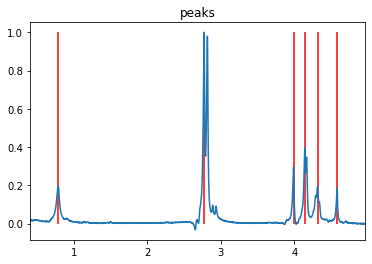

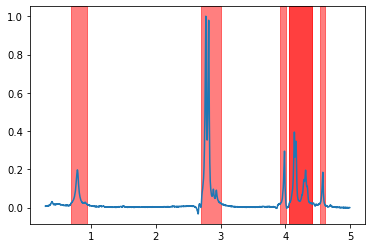

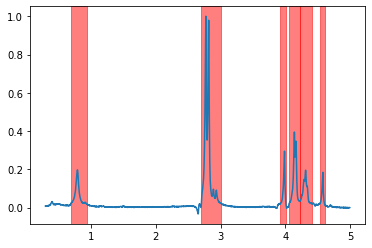

In [57]:
df = work_nmr(file,show_peaks=True)

In [58]:
df

,idx,y_value,x_value,lower_bound,upper_bound,area
0,30491,0.197213,0.787108,30433,30572,2.940082
1,31624,1.000000,2.772030,31585,31762,12.859004
2,32318,0.294956,3.987863,32280,32331,1.627707
3,32405,0.394850,4.140277,32360,32452,4.197686
4,32504,0.195567,4.313720,32452,32560,2.853509
5,32656,0.184623,4.580012,32630,32672,1.000000


In [59]:
df.to_csv("peak_res.csv")